## Quantum Approximate Optimisation Algorithm in Python

This notebook demostrates how the package in this repository can be used to solve quadratic unconstrained binary optimisation (QUBO) problems, expressed in the context of the max-cut problem from graph theory, using a quantum algorithm.

We start by first defining the graph using the $\texttt{networkx}$ package in Python. In this example we will be considering a quite simple complete graph with 4 vertices, where the weights of each edge are
uniformly distributed between 0 and 1.

In [25]:
import networkx as nx
from src_code import get_data
import random

def generate_graph(n, seed=1):

    graph = nx.Graph()
    edge_list = []
    for n_1 in range(n):

        for n_2 in range(n_1+1, n):

            edge_list.append((n_1, n_2))
            
    graph.add_edges_from(edge_list)

    random.seed(seed)
    # weights = [random.random() for i in range(len(edge_list))]
    weights = [1 for i in range(len(edge_list))]

    for index, edge in enumerate(graph.edges()):
        graph.get_edge_data(*edge)['weight'] = weights[index]

    return graph, weights

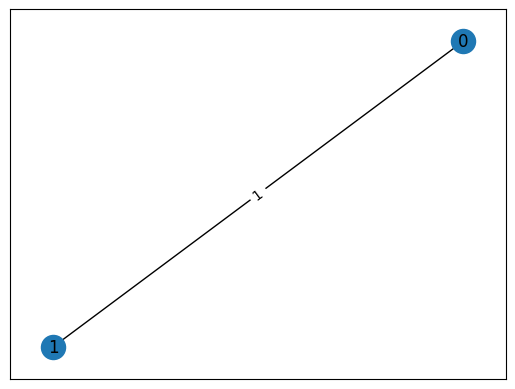

In [26]:
no_vertices = 2
graph = generate_graph(no_vertices)[0]
pos=nx.circular_layout(graph)
nx.draw_networkx(graph, pos)
labels = nx.get_edge_attributes(graph,'weight')
for edge in labels:
    labels[edge] = round(labels[edge], 3)
tmp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

Once we have generated the graph, we can define the Ising Hamiltonian whose maximum energy eigenstate corresponds to the solution to the problem. This is given by $$\hat{H}_C=-\frac{1}{4}\sum_{i,j=0}^{n-1}W_{ij}\hat{Z}_i\hat{Z}_j.$$ It should be noted that the eigenvalues of this Hamiltonian are not exactly equal to the values of their corresponding cuts. They differ by a constant term $A = \frac{1}{4}\sum_{i,j=0}^{n-1}W_{ij}$, which is removed as it doesn't influence to the operation of the algorithm. It is later added back in to generate correct results. Additionally, we can define all the commutators $$\left[\hat{H}_C,-i\hat{A}\right]\quad\forall \quad\hat{A}\in\mathcal{P}.$$ These are used to find the gradients in parameter space at each iteration which are used to determine which mixer operator from the pool $\mathcal{P}$ to be added to the ADAPT-QAOA circuit in the current layer.

In [27]:
from src_code import build_operators

hamiltonian = build_operators.cut_hamiltonian(graph=graph)
# gradient_ops_dict = build_operators.build_all_mixers(graph=graph)

In order to make the generation of the unitaries in the ansatz quicker between iterations of both the overall algorithm and the classical optimsation scheme, it is useful to pre-compute all the Pauli strings appearing in the exponents of the unitaries. This then allows one to use the identity $$e^{i\alpha\hat{P}}=\cos(\alpha)\hat{I}+i\sin(\alpha)\hat{P}$$ for single Pauli strings, to find the unitaries using simple floating point arithmetic, rather than matrix exponentiation during each iteration.

In [28]:
pauli_ops_dict = build_operators.build_all_paulis(no_vertices)

All this pre-computation allows for significant speed-up in the execution of the algorithms. We now move on to actually running QAOA on the graph. We first perform the standard non-adaptive algorithm. To do so we require to pick a specific depth for the circuit, i.e., the number of layers it will contain. We set this to 5.

In [29]:
circuit_depth = 1
qaoa_solution = get_data.run_standard_qaoa(graph, depth=circuit_depth, pauli_ops_dict=pauli_ops_dict)

In [30]:
for key in qaoa_solution:
    print(key+':', qaoa_solution[key])

cut_approx_ratio: 0.9999999999996869
ham_approx_ratio: 0.9999999999993738
optimised_Hamiltonian_unitary_parameters: [1.5707973806736546]
optimised_mixer_unitary_parameters: [0.39269898780165796]


We now move on the ADAPT-QAOA. We use the same maximum depth of 5 as above.

In [7]:
adapt_qaoa_solution = get_data.run_adapt_qaoa(graph, pauli_ops_dict, gradient_ops_dict, circuit_depth)

Initial Cut Approximation Ratio: 0.6236084656002482 

Finding Best Mixer for layer 1...
	Best mixer is Y2Z0 with gradient magnitude 0.8473693563043921

Optimising layer 1...
	Initial Parameter Guesses: [0.0, 0.01]
	Optimisation completed wih following outcome:
		Number of iterations performed: 3
		Number of expectation evaluations performed: 12
		Success: True
		Optimiser message: Optimization terminated successfully.
	Optimised mixer unitary parameters: 0.785
	Optimised Hamiltonian unitary parameters: 0.00222

Current Cut Approximation Ratio: 0.803018653875865


Finding Best Mixer for layer 2...
	Best mixer is Y1Z3 with gradient magnitude 0.4954255357785279

Optimising layer 2...
	Initial Parameter Guesses: [0.7853871465115431, 0.0, 0.00222223952117778, 0.01]
	Optimisation completed wih following outcome:
		Number of iterations performed: 2
		Number of expectation evaluations performed: 20
		Success: True
		Optimiser message: Optimization terminated successfully.
	Optimised mixer unit

In [8]:
for key in adapt_qaoa_solution:
    if key == 'all_mixers':
        continue
    print(key+':', adapt_qaoa_solution[key])

cut_approx_ratios: [0.6236084656002482, 0.803018653875865, 0.9079069189947225, 0.9079082780494606, 0.999999999987315, 0.9999999999999932]
ham_approx_ratios: [3.122362835725594e-17, 0.47665840455665454, 0.7553263753603213, 0.7553299861076787, 0.9999999999662985, 0.999999999999982]
best_mixers: ['Y2Z0', 'Y1Z3', 'standard_x', 'Y0Y2', 'Y0Y2']
best_mixer_parameters: [0.7853980385905645, 0.7853980901285611, 4.868277665597093e-08, 0.7853949253054838, 3.2222304533041107e-06]
best_ham_parameters: [1.0845389440903889e-07, 2.9052681164851994e-07, 1.2889044295043048, 2.322217314096507, 0.009999992591315112]


Finally, we solve the problem using the Dynamic ADAPT-QAOA which determines at each layer whether it is beneficial to the classical optimisation to include a Hamiltonian unitary or not. To do this, it is useful to generate a dictionary containing splits of each mixer operator into two operators, one which commutes with the Hamiltonian, and one which anti-commutes with it. This is possible for all mixers which are single Pauli strings.

In [9]:
pauli_mixers_split_ops_dict = build_operators.split_all_mixers(graph)

In [10]:
dynamic_adapt_qaoa_solution = get_data.run_dynamic_adapt_qaoa(graph, pauli_ops_dict, gradient_ops_dict, pauli_mixers_split_ops_dict, max_depth=circuit_depth)

Initial Cut Approximation Ratio: 0.6236084656002482 

Finding Best Mixer for layer 1...
	The best mixer for layer 1 with no Hamiltonian unitary is Y2Z0 with a gradient of 0.8474337369372327
	<iMH_a> = 0.42371686846861634
	<MH_a^2> = 0
	<iMH_a^3> = 0.16095427756252523
	A maximum occurs when using no Hamiltonian unitary so we remove it for this layer!

Optimising layer 1...
	Initial Parameter Guesses: [0.0]
	Optimisation completed wih following outcome:
		Number of iterations performed: 3
		Number of expectation evaluations performed: 8
		Success: True
		Optimiser message: Optimization terminated successfully.
	Optimised mixer unitary parameters: 0.785
	Optimised Hamiltonian unitary parameters

Current Cut Approximation Ratio: 0.8030193264617695


Finding Best Mixer for layer 2...
	The best mixer for layer 2 with no Hamiltonian unitary is Y3Z1 with a gradient of 0.495435087091941
	<iMH_a> = 0.2477175435459705
	<MH_a^2> = 0
	<iMH_a^3> = 0.03355200293918671
	A maximum occurs when using no 

In [11]:
for key in dynamic_adapt_qaoa_solution:
    if key == 'all_mixers':
        continue
    print(key+':', dynamic_adapt_qaoa_solution[key])

cut_approx_ratios: [0.6236084656002482, 0.8030193264617695, 0.9079081933439633, 0.9079082780844338, 0.9999999988163014, 0.9999999999990794]
ham_approx_ratios: [3.122362835725594e-17, 0.47666019148819516, 0.7553297610614449, 0.7553299862005955, 0.9999999968551402, 0.999999999997554]
best_mixers: ['Y2Z0', 'Y3Z1', 'Y1Z3', 'X1X3', 'Y0Z2']
best_mixer_parameters: [0.7853973423672501, 0.7850807716996512, 0.0003174651773739743, 0.7853978048085118, 7.067406999878113e-07]
best_ham_parameters: [3.6111322479525, 0.10000004066166757]
ham_unitary_layers: [4, 5]


Overall, we see that the three algorithm implementations converge to a good approximation ratio, with the adaptive problem-tailored ones achieving better results. The dynamic algorithm converges quicker compared to the non-dynamic version.